# Prework

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import scipy.ndimage as ndi
import pandas as pd
import os
import pathlib
import copy
import torch
import math
from collections import Counter
import sys

In [2]:
train_dir = '../input/prostate15/prostate158_train/prostate158_train'
train_csv = os.path.join(train_dir, 'train.csv')
train_valid_csv = os.path.join(train_dir, 'valid.csv')

test_dir = '../input/prostate15/prostate158_test/prostate158_test'
test_csv = os.path.join(test_dir, 'test.csv')

In [3]:
train_df = pd.read_csv(train_csv)
valid_df = pd.read_csv(train_valid_csv)
test_df = pd.read_csv(test_csv)

In [4]:
def remove_compression_suffix(df):
    columns = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 't2_anatomy_reader2', 'adc_tumor_reader2']
    df[columns] = df[columns].map(lambda v: '.'.join(x for x in v.split('.')[:-1]) if isinstance(v, str) else v)
    return df

In [5]:
train_df = remove_compression_suffix(train_df)
valid_df = remove_compression_suffix(valid_df)
test_df = remove_compression_suffix(test_df)
train_df.head()

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii,train/024/adc.nii,train/024/dwi.nii,train/024/t2_anatomy_reader1.nii,NaN,train/024/empty.nii,NaN,NaN
1,25,train/025/t2.nii,train/025/adc.nii,train/025/dwi.nii,train/025/t2_anatomy_reader1.nii,train/025/t2_tumor_reader1.nii,train/025/adc_tumor_reader1.nii,NaN,train/025/adc_tumor_reader2.nii
2,26,train/026/t2.nii,train/026/adc.nii,train/026/dwi.nii,train/026/t2_anatomy_reader1.nii,NaN,train/026/empty.nii,NaN,NaN
3,27,train/027/t2.nii,train/027/adc.nii,train/027/dwi.nii,train/027/t2_anatomy_reader1.nii,train/027/t2_tumor_reader1.nii,train/027/adc_tumor_reader1.nii,NaN,train/027/adc_tumor_reader2.nii
4,28,train/028/t2.nii,train/028/adc.nii,train/028/dwi.nii,train/028/t2_anatomy_reader1.nii,NaN,train/028/empty.nii,NaN,NaN


# Prostate158 - Eploratory data analysis

In [6]:
train_df.head()

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,24,train/024/t2.nii,train/024/adc.nii,train/024/dwi.nii,train/024/t2_anatomy_reader1.nii,NaN,train/024/empty.nii,NaN,NaN
1,25,train/025/t2.nii,train/025/adc.nii,train/025/dwi.nii,train/025/t2_anatomy_reader1.nii,train/025/t2_tumor_reader1.nii,train/025/adc_tumor_reader1.nii,NaN,train/025/adc_tumor_reader2.nii
2,26,train/026/t2.nii,train/026/adc.nii,train/026/dwi.nii,train/026/t2_anatomy_reader1.nii,NaN,train/026/empty.nii,NaN,NaN
3,27,train/027/t2.nii,train/027/adc.nii,train/027/dwi.nii,train/027/t2_anatomy_reader1.nii,train/027/t2_tumor_reader1.nii,train/027/adc_tumor_reader1.nii,NaN,train/027/adc_tumor_reader2.nii
4,28,train/028/t2.nii,train/028/adc.nii,train/028/dwi.nii,train/028/t2_anatomy_reader1.nii,NaN,train/028/empty.nii,NaN,NaN


In [7]:
test_df

,ID,t2,adc,dwi,t2_anatomy_reader1,t2_tumor_reader1,adc_tumor_reader1,t2_anatomy_reader2,adc_tumor_reader2
0,1,test/001/t2.nii,test/001/adc.nii,test/001/dwi.nii,test/001/t2_anatomy_reader1.nii,test/001/t2_tumor_reader1.nii,test/001/adc_tumor_reader1.nii,test/001/t2_anatomy_reader2.nii,test/001/adc_tumor_reader2.nii
1,2,test/002/t2.nii,test/002/adc.nii,test/002/dwi.nii,test/002/t2_anatomy_reader1.nii,test/002/t2_tumor_reader1.nii,test/002/adc_tumor_reader1.nii,test/002/t2_anatomy_reader2.nii,test/002/adc_tumor_reader2.nii
2,3,test/003/t2.nii,test/003/adc.nii,test/003/dwi.nii,test/003/t2_anatomy_reader1.nii,test/003/t2_tumor_reader1.nii,test/003/adc_tumor_reader1.nii,test/003/t2_anatomy_reader2.nii,test/003/adc_tumor_reader2.nii
3,4,test/004/t2.nii,test/004/adc.nii,test/004/dwi.nii,test/004/t2_anatomy_reader1.nii,test/004/t2_tumor_reader1.nii,test/004/adc_tumor_reader1.nii,test/004/t2_anatomy_reader2.nii,test/004/adc_tumor_reader2.nii
4,5,test/005/t2.nii,test/005/adc.nii,test/005/dwi.nii,test/005/t2_anatomy_reader1.nii,test/005/t2_tumor_reader1.nii,test/005/adc_tumor_reader1.nii,test/005/t2_anatomy_reader2.nii,test/005/adc_tumor_reader2.nii
5,6,test/006/t2.nii,test/006/adc.nii,test/006/dwi.nii,test/006/t2_anatomy_reader1.nii,test/006/t2_tumor_reader1.nii,test/006/adc_tumor_reader1.nii,test/006/t2_anatomy_reader2.nii,test/006/adc_tumor_reader2.nii
6,7,test/007/t2.nii,test/007/adc.nii,test/007/dwi.nii,test/007/t2_anatomy_reader1.nii,test/007/t2_tumor_reader1.nii,test/007/adc_tumor_reader1.nii,test/007/t2_anatomy_reader2.nii,test/007/adc_tumor_reader2.nii
7,8,test/008/t2.nii,test/008/adc.nii,test/008/dwi.nii,test/008/t2_anatomy_reader1.nii,test/008/t2_tumor_reader1.nii,test/008/adc_tumor_reader1.nii,test/008/t2_anatomy_reader2.nii,test/008/adc_tumor_reader2.nii
8,9,test/009/t2.nii,test/009/adc.nii,test/009/dwi.nii,test/009/t2_anatomy_reader1.nii,test/009/t2_tumor_reader1.nii,test/009/adc_tumor_reader1.nii,test/009/t2_anatomy_reader2.nii,test/009/adc_tumor_reader2.nii
9,10,test/010/t2.nii,test/010/adc.nii,test/010/dwi.nii,test/010/t2_anatomy_reader1.nii,test/010/t2_tumor_reader1.nii,test/010/adc_tumor_reader1.nii,test/010/t2_anatomy_reader2.nii,test/010/adc_tumor_reader2.nii


## Columns' description&ast;
* **ID** – patient MRI identificator
* **t2** – t2 sequence in NIfTI format
* **adc** – ADC sequence in NIfTI format
* **dwi** – DWI sequence in NIfTI format
* **t2_anatomy_reader1** – Anatomy segmentation of reader 1
* **t2_anatomy_reader2** – Anatomy segmentation of reader 2&ast;&ast;
* **t2_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader1** – Tumor segmentation of reader 1
* **adc_tumor_reader2** – Tumor segmentation of reader 2

<details>
    <summary>Abbreviations</summary>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Apparent diffusion coefficient?</a>
    - <a href="https://radiopaedia.org/articles/apparent-diffusion-coefficient-1">What is Diffusion-weighted imaging?</a>
</details>

###### &ast;Based on https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9679750/pdf/main.pdf, &ast;&ast;own caption


## Missing data per dataset part

In [8]:
for label, df in {'Train Set': train_df, 'Training Validation Set': valid_df, 'Test Set': test_df}.items():
    na_vals = pd.isna(df).sum()
    percent_missing = na_vals / df.shape[0]
    percent_missing = percent_missing.apply(lambda x: f"{x:.2%}")
    print(label)
    print(pd.DataFrame({'count missing': na_vals, 'percent_missing': percent_missing}).sort_values(by='count missing', ascending=False))
    print('\n' * 2)

Train Set
                    count missing percent_missing
t2_anatomy_reader2            119         100.00%
adc_tumor_reader2              62          52.10%
t2_tumor_reader1               49          41.18%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_reader1               0           0.00%



Training Validation Set
                    count missing percent_missing
t2_anatomy_reader2             20         100.00%
adc_tumor_reader2              10          50.00%
t2_tumor_reader1                8          40.00%
ID                              0           0.00%
t2                              0           0.00%
adc                             0           0.00%
dwi                             0           0.00%
t2_anatomy_reader1              0           0.00%
adc_tumor_rea

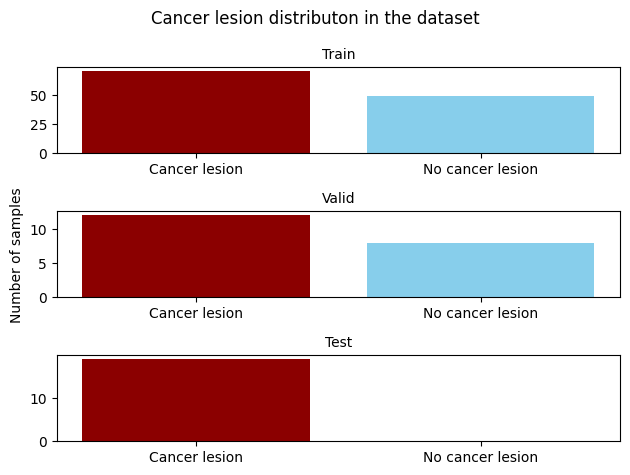

In [9]:
has_tumor_file = lambda x: type(x) is str
train_counts = train_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)
valid_counts = valid_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)
test_counts = test_df['t2_tumor_reader1'].map(has_tumor_file).value_counts(bins=2)

fig, ax = plt.subplots(3, 1)
bar_colors = ['darkred', 'skyblue']

labels = ['Cancer lesion', 'No cancer lesion']
ax[0].bar(labels, train_counts, color=bar_colors)
ax[0].set_title('Train', fontsize=10)

ax[1].bar(labels, valid_counts, color=bar_colors)
ax[1].set_ylabel('Number of samples')
ax[1].set_title('Valid', fontsize=10)

ax[2].bar(labels, test_counts, color=bar_colors)
ax[2].set_title('Test', fontsize=10)

plt.suptitle('Cancer lesion distributon in the dataset')
plt.tight_layout()
plt.show()

More than half of the cases of the training data seems to have cancerous lesions

## Shape of the data

In [10]:
def load_nii(f_name, dir=train_dir):
    if (isinstance(f_name, str) == False):
        raise Exception(f'Invalid filepath "{f_name}"" is not a string')
    img = nib.load(os.path.join(dir, f_name))
    data = img.get_fdata()
    return (img, data)

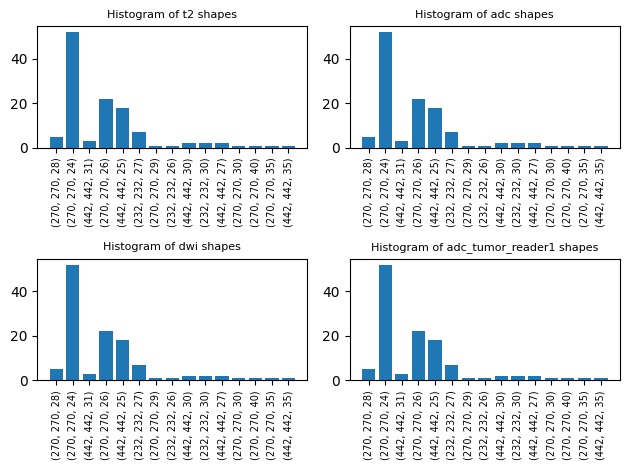

In [11]:
series = ('t2', 'adc', 'dwi', 'adc_tumor_reader1')
fig, axs = plt.subplots(2, 2)
for i, s in enumerate(series):    
    img_shapes = []
    for f_name in train_df[s]:
        try:
            img, _ = load_nii(f_name)
        except:
            pass
        else:
            img_shapes.append(img.shape)
    counter = Counter(img_shapes)
    labels = [str(t) for t in list(counter.keys())]
    counts = list(counter.values())
    axs.flat[i].bar(labels, counts)
    axs.flat[i].set_xticks(labels, labels, rotation=90, fontsize=7)
    axs.flat[i].set_title(f'Histogram of {s} shapes', fontsize=8)
plt.tight_layout()
plt.show()

Ensure each sample has the same size witihin case

In [12]:
series = ['t2', 'adc', 'dwi', 'adc_tumor_reader1']

for i, row in train_df[series][:3].iterrows():
    shapes = set()
    for s in series:
        img, _ = load_nii(row[s])
        shapes.add(str(img.shape))
    if len(shapes) != 1:
        raise Exception(f'Sample {i} has incorrect shape!')
print('OK!')

OK!


## Samples visualisation

In [ ]:
t2, t2_data = load_nii(train_df.iloc[2]['t2'])
t2_slice = t2_data[:, :]
img_count = t2_slice.shape[-1]
cols = 4
rows = img_count // cols + (0 if img_count % cols == 0 else 1)
fig, axs = plt.subplots(min(rows, 3), cols)
for i in range(min(img_count, 12)):
    axs.flat[i].imshow(ndi.rotate(t2_slice[:,:,i], 90), cmap='gray')
    axs.flat[i].axis('off')
    
fig.suptitle('Axial slice of the T2 images', size='small')
plt.axis('off')
plt.tight_layout()
plt.show()

In contrast to "classic" images made of 2D pixels, MRI scans usually consist of voxels. A voxel can be imagined as a three-dimensional pixel.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12,4), constrained_layout=True)

ax[0].set_title('Axial (look down)')
ax[0].imshow(np.rot90(t2_data[:,:,0]), cmap='gray')
ax[0].axis('off')

ax[1].set_title('Coronal (look from the front)')
ax[1].imshow(np.rot90(t2_data[:,0,:]), cmap='gray')
ax[1].axis('off')

ax[2].set_title('Sagittal (look from the side)')
ax[2].imshow(np.rot90(t2_data[0,:,:]), cmap='gray')
ax[2].axis('off')

fig.suptitle('Different type of slices of the prostate MRI', fontsize=14)
plt.show()

In [ ]:
def process_slice(data, selected_image, mask=False):
    img_slice = data[:, :, selected_image]
    img_slice = np.rot90(img_slice)
    if mask:
        img_slice = np.ma.masked_where(img_slice == 0, img_slice)
    return img_slice

def plot_images(axs, titles, base_img, overlay_imgs=None, overlay_alpha=0.5, cmap='gray', overlay_cmap='autumn'):
    for ax, title, overlay in zip(axs, titles, overlay_imgs or (None for _ in axs)):
        ax.set_title(title, fontsize=9)
        ax.imshow(base_img, cmap=cmap)
        if overlay is not None:
            ax.imshow(overlay, alpha=overlay_alpha, cmap=overlay_cmap)
        ax.axis('off')

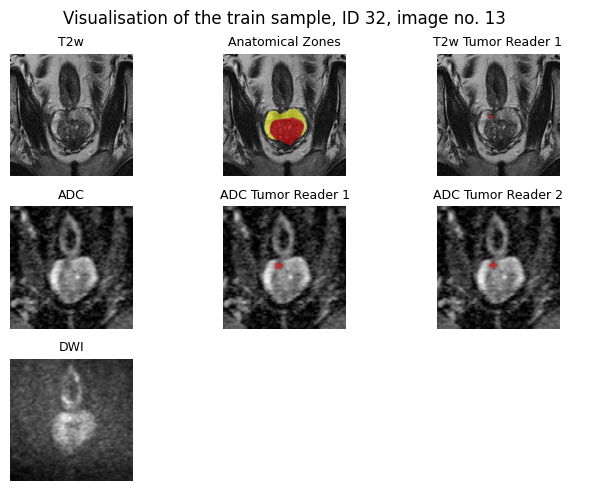

In [115]:
CASE = 32
SET = train_df
SELECTED_IMG = 13

row = SET.loc[SET['ID'] == CASE]

data_files = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2']
data = {key: load_nii(row[key].values.item())[1] for key in data_files}

t2_slice, dwi_slice, adc_slice = [process_slice(data[fname], SELECTED_IMG) for fname in ('t2', 'dwi', 'adc')]
t2_ar1_slice, t2_tr1_slice, adc_tr1_slice, adc_tr2_slice = [process_slice(data[fname], SELECTED_IMG, mask=True) for fname in ('t2_anatomy_reader1', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2')]

fig = plt.figure(constrained_layout=True)
fig.suptitle(f"Visualisation of the train sample, ID {row['ID'].values.item()}, image no. {SELECTED_IMG}")
subfigs = fig.subfigures(3, 1)

axsTop = subfigs[0].subplots(1, 3)
plot_images(axsTop, ['T2w', 'Anatomical Zones', 'T2w Tumor Reader 1'], t2_slice, [None, t2_ar1_slice, t2_tr1_slice])

axsMiddle = subfigs[1].subplots(1, 3)
plot_images(axsMiddle, ['ADC', 'ADC Tumor Reader 1', 'ADC Tumor Reader 2'], adc_slice, [None, adc_tr1_slice, adc_tr2_slice])

axsBottom = subfigs[2].subplots(1, 3)
plot_images(axsBottom, ['DWI'], dwi_slice)
for ax in axsBottom[1:]:
    ax.axis('off')

plt.show()

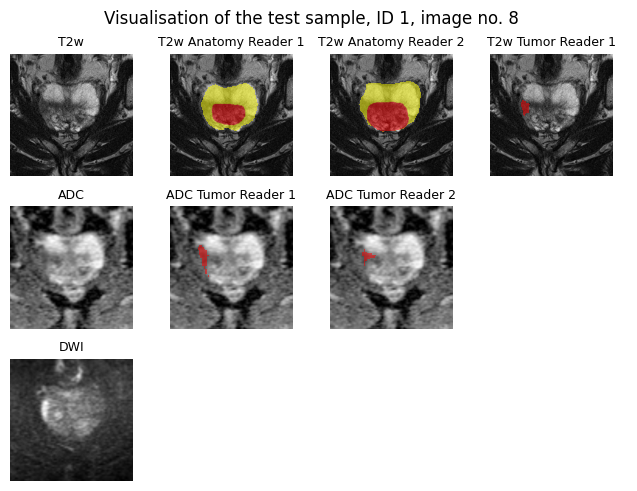

In [95]:
CASE = 1
SET = test_df
SELECTED_IMG = 8

row = SET.loc[SET['ID'] == CASE]

data_files = ['t2', 'adc', 'dwi', 't2_anatomy_reader1', 't2_anatomy_reader2', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2']
data = {key: load_nii(row[key].values.item(), dir=test_dir)[1] for key in data_files}

t2_slice, dwi_slice, adc_slice = [process_slice(data[fname], SELECTED_IMG) for fname in ('t2', 'dwi', 'adc')]
t2_ar1_slice, t2_ar2_slice, t2_tr1_slice, adc_tr1_slice, adc_tr2_slice = [process_slice(data[fname], SELECTED_IMG, mask=True) for fname in ('t2_anatomy_reader1', 't2_anatomy_reader2', 't2_tumor_reader1', 'adc_tumor_reader1', 'adc_tumor_reader2')]

fig = plt.figure(constrained_layout=True)
fig.suptitle(f"Visualisation of the test sample, ID {row['ID'].values.item()}, image no. {SELECTED_IMG}")
subfigs = fig.subfigures(3, 1)

axsTop = subfigs[0].subplots(1, 4)
plot_images(axsTop, ['T2w', 'T2w Anatomy Reader 1', 'T2w Anatomy Reader 2', 'T2w Tumor Reader 1'], t2_slice, [None, t2_ar1_slice, t2_ar2_slice, t2_tr1_slice])

axsMiddle = subfigs[1].subplots(1, 4)
plot_images(axsMiddle, ['ADC', 'ADC Tumor Reader 1', 'ADC Tumor Reader 2'], adc_slice, [None, adc_tr1_slice, adc_tr2_slice])
for ax in axsMiddle[3:]:
    ax.axis('off')

axsBottom = subfigs[2].subplots(1, 4)
plot_images(axsBottom, ['DWI'], dwi_slice)
for ax in axsBottom[1:]:
    ax.axis('off')

plt.show()

# Pipeline setup – nnU-Net

## Installing NVIDIA Apex (GPU Required) / everytime notebook runs
*(it takes around 15-25 minutes)*

In [18]:
!git clone https://github.com/NVIDIA/apex

fatal: destination path 'apex' already exists and is not an empty directory.


In [19]:
os.chdir(os.path.join(os.getcwd(), 'apex'))
!pip install -v --disable-pip-version-check --no-cache-dir --no-build-isolation --config-settings "--build-option=--cpp_ext" --config-settings "--build-option=--cuda_ext" ./
os.chdir(os.path.join(os.getcwd(), '..'))
os.getcwd()

Using pip 23.3.2 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)
Processing /kaggle/working/apex
  Running command Preparing metadata (pyproject.toml)

   If your intention is to cross-compile, this is not an error.
  By default, Apex will cross-compile for Pascal (compute capabilities 6.0, 6.1, 6.2),
  Volta (compute capability 7.0), Turing (compute capability 7.5),
  and, if the CUDA version is >= 11.0, Ampere (compute capability 8.0).
  If you wish to cross-compile for a single specific architecture,
  export TORCH_CUDA_ARCH_LIST="compute capability" before running setup.py.



  torch.__version__  = 2.1.2+cpu


  Traceback (most recent call last):
    File "/opt/conda/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
      main()
    File "/opt/conda/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs']

'/kaggle/working'

Check if installation was successful

In [20]:
from apex import amp
dir(amp)

ImportError: cannot import name 'amp' from 'apex' (unknown location)

## [Installing nnU-Net](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/installation_instructions.md#installation-instructions)
*It should take no more than 3 minutes*

In [39]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
os.chdir(os.path.join('/', 'kaggle', 'working'))
os.chdir(os.path.join(os.getcwd(), 'nnUNet'))
!pip install -e .
# The line below is optional – plots for the training
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git
os.chdir(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), 'nnUNet'))

fatal: destination path 'nnUNet' already exists and is not an empty directory.
Obtaining file:///kaggle/working/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━

## [Setup variables for the nnU-Net](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md)

In [28]:
os.chdir('/kaggle/working/')
if (os.getcwd() != '/kaggle/working'):
    raise Exception(f'Not in the working catalog! Current catalog: {os.getcwd()}')

raw_dataset_catalog = os.path.join(pathlib.Path(os.getcwd()).parent.absolute(), 'input', 'prostate158-nnunet-raw', 'nnUNet_raw')
# Task should be in format TaskXXX_\s+; 
task_name = 'Dataset158_Prostate158'
# Not persisted after the session is closed!
preprocessed_catalog = os.path.join(pathlib.Path(os.getcwd()).parent.absolute(), 'tmp', 'preprocessed')
# There the weights of the model will be stored
results_catalog = os.path.join(os.getcwd(), 'results')

os.environ['nnUNet_raw'] = raw_dataset_catalog
os.environ['nnUNet_preprocessed'] = preprocessed_catalog
os.environ['nnUNet_results'] = results_catalog
!echo nnUNet_raw = $nnUNet_raw
!echo nnUNet_preprocessed = $nnUNet_preprocessed
!echo nnUNet_results = $nnUNet_results

nnUNet_raw = /kaggle/input/prostate158-nnunet-raw/nnUNet_raw
nnUNet_preprocessed = /kaggle/tmp/preprocessed
nnUNet_results = /kaggle/working/results


## Ensure all the paths are set correctly

In [37]:
if not os.path.exists(os.path.join(raw_dataset_catalog, task_name)):
    raise NotADirectoryError(f'No data for the nnU-Net in: {os.path.join(raw_dataset_catalog, task_name)}')
else:
    print('1. nnUNet data available.')

if not os.path.isdir(preprocessed_catalog):
    os.makedirs(preprocessed_catalog)
if not os.path.isdir(preprocessed_catalog):
    raise NotADirectoryError(f'There is no preprocessed folder under {preprocessed_catalog}')
else:
    print('2. Preprocessed folder set!')

if not os.path.isdir(results_catalog):
    os.makedirs(results_catalog)
if not os.path.isdir(results_catalog):
    raise NotADirectoryError(f'There is no results folder under {results_catalog}')
else:
    print('3. Results folder set!')

1. nnUNet data available.
2. Preprocessed folder set!
3. Results folder set!


## Extract fingerprint, create plans & preprocess the dataset

In [117]:
!nnUNetv2_plan_and_preprocess -d 158 --verify_dataset_integrity -pl nnUNetPlannerResEncM

Fingerprint extraction...
Dataset158_Prostate158
Using <class 'nnunetv2.imageio.nibabel_reader_writer.NibabelIO'> as reader/writer
Affine image: [[-2.71739006e-01  1.33070584e-12  0.00000000e+00  6.00543671e+01]
 [-1.33070584e-12 -2.71739006e-01  0.00000000e+00  3.86654663e+01]
 [ 0.00000000e+00  0.00000000e+00  2.99999833e+00 -6.90554962e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
Affine seg: [[-2.71739006e-01  1.33070584e-12  0.00000000e+00 -1.00000000e+00]
 [-1.33070584e-12 -2.71739006e-01  0.00000000e+00  4.89699991e-12]
 [ 0.00000000e+00  0.00000000e+00  2.99999833e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Image files: ['/kaggle/input/prostate158-nnunet-raw/nnUNet_raw/Dataset158_Prostate158/imagesTr/prostate_055_0000.nii', '/kaggle/input/prostate158-nnunet-raw/nnUNet_raw/Dataset158_Prostate158/imagesTr/prostate_055_0001.nii', '/kaggle/input/prostate158-nnunet-raw/nnUNet_raw/Dataset158_Prostate158/imagesTr

In [108]:
!nnUNetv2_plot_overlay_pngs -d 158 -o /kaggle/working/plot_overlay2 -channel_idx 1 #adc channel

/kaggle/working/nnUNet/nnunetv2/utilities/overlay_plots.py:126: RuntimeWarning: Mean of empty slice.
  fg_per_slice = fg_per_slice.mean(1)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/kaggle/working/nnUNet/nnunetv2/utilities/overlay_plots.py:82: RuntimeWarning: invalid value encountered in divide
  image = image / image.max() * 255
/kaggle/working/nnUNet/nnunetv2/utilities/overlay_plots.py:94: RuntimeWarning: invalid value encountered in cast
  return image.astype(np.uint8)
/kaggle/working/nnUNet/nnunetv2/utilities/overlay_plots.py:126: RuntimeWarning: Mean of empty slice.
  fg_per_slice = fg_per_slice.mean(1)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/kaggle/working/nnUNet/nnunetv2/utilities/overlay_plots.py:82: RuntimeWarning: invalid value encountered in divide
  image = image / image

## Visualise plots after preprocessing
Despite having different affines, everything looks valid after preprocessing. Below a sample from the train dataset, ID 31, image 13 and the plotted png by nnUNet

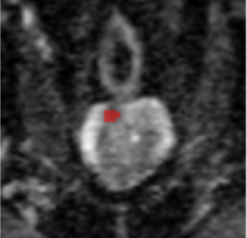
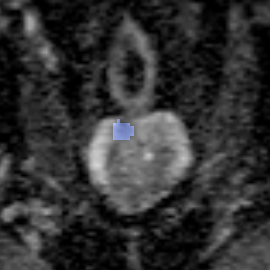

# Training

In [116]:
!nnUNetv2_train -h

usage: nnUNetv2_train [-h] [-tr TR] [-p P]
                      [-pretrained_weights PRETRAINED_WEIGHTS]
                      [-num_gpus NUM_GPUS] [--use_compressed] [--npz] [--c]
                      [--val] [--val_best] [--disable_checkpointing]
                      [-device DEVICE]
                      dataset_name_or_id configuration fold

positional arguments:
  dataset_name_or_id    Dataset name or ID to train with
  configuration         Configuration that should be trained
  fold                  Fold of the 5-fold cross-validation. Should be an int
                        between 0 and 4.

options:
  -h, --help            show this help message and exit
  -tr TR                [OPTIONAL] Use this flag to specify a custom trainer.
                        Default: nnUNetTrainer
  -p P                  [OPTIONAL] Use this flag to specify a custom plans
                        identifier. Default: nnUNetPlans
  -pretrained_weights PRETRAINED_WEIGHTS
                        [O

In [121]:
!nnUNetv2_train 158 2d 0 -p nnUNetResEncUNetMPlans

Using device: cuda:0
/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-07-20 14:26:52.743340: do_dummy_2d_data_aug: False
2024-07-20 14:26:52.744413: Using splits from existing split file: /kaggle/tmp/preprocessed/Dataset158_Prostate158/splits_final.json
2024-07-20 14:26:52.744774: The split file contains 5 splits.
2024-07-20 14:26:52.744897: Desired fold for training: 0
2024-07-20 14:26:52.744999: This split has 70 training and 18 validation cases.
Except